# Logistic Regression with Gradient Descent algorithm

### Imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

### Generate dataset

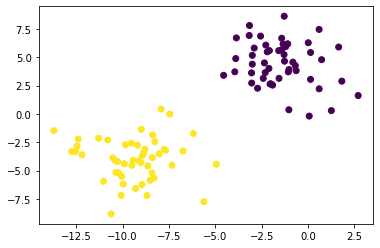

In [2]:
### Blobs
x, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=2, random_state=1)
plt.scatter(x[:, 0], x[:, 1], c=y);

### Transform features

Let us add bias using `PolynomialFeatures`.

In [3]:
#@title Solution { display-mode: "form" }
poly = PolynomialFeatures(degree=1, include_bias=True)
x_transformed = poly.fit_transform(x)
x_transformed.shape

(100, 3)

### Train-test split

* Split data into 80:20 train:test split.
* Use 10% of the train data as validation data.

> Hint: use `train_test_split` function from scikit-learn

In [4]:
#@title Solution { display-mode: "form" }
def get_train_val_test_split(x, y):
  x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, train_size=0.8, random_state=0)
  x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1, random_state=0)
  return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = get_train_val_test_split(x_transformed, y)
x_train.shape, x_val.shape, x_test.shape

((72, 3), (8, 3), (20, 3))

### Initialize parameters

Initialize learnable parameters for the above dataset. You can use `jnp` just like regular numpy.

In [5]:
#@title Solution { display-mode: "form" }
theta = jnp.array([0.1, 0.2, 0.3])

### Loss function
\begin{equation}
\operatorname{Loss}=-\frac{1}{\substack{\text { output } \\ \text { size }}} \sum_{i=1}^{\substack{\text { output } \\ \text { size }}} y_{i} \cdot \log \hat{y}_{i}+\left(1-y_{i}\right) \cdot \log \left(1-\hat{y}_{i}\right)
\end{equation}

Implement the cross entropy loss function which takes parameters as its first input.

> Hint: You can use the following sigmoid function: `jax.nn.sigmoid`

In [6]:
#@title Solution { display-mode: "form" }

def predict_fn(theta, x):
  logits = jnp.dot(x, theta) # OR x@theta
  y_pred = jax.nn.sigmoid(logits)
  return y_pred

def loss_fn(theta, x, y):
  y_pred = predict_fn(theta, x)
  loss = -(y * jnp.log(y_pred) + (1-y) *  jnp.log(1-y_pred))
  return loss.mean()

### Evaluate the loss function at initial parameters

In [7]:
#@title Solution { display-mode: "form" }
loss_fn(theta, x_train, y_train)

DeviceArray(2.3427932, dtype=float32)

### Define the gradient function

In JAX, you can apply `jax.grad` function on your loss function to get corresponding gradient function. The gradient function takes same arguments as the loss function but it returns the gradient of loss instead of loss.

`jax.grad` takes your loss function as input and outputs the gradient function.

In [8]:
#@title Solution { display-mode: "form" }
grad_fn = jax.grad(loss_fn)

### Define `learning_rate` and `n_iterations`

One should choose appropriate `learning_rate` and `n_iterations` to make sure loss converges. You can set initial values based on your intuition and then adjust them based on loss convergence diagnostics.

In [9]:
#@title Solution { display-mode: "form" }
learning_rate = 0.1
n_iterations = 100

### Optimize the parameters using the gradient descent algorithm

* You should use the gradient function you have defined earlier.
* You can implement a for loop running the algorithm `n_iterations` times.
* You should append the training and validation loss in a list after each iteration for later diagnostics.

In [10]:
#@title Solution { display-mode: "form" }
def train_fn(theta):
  train_losses = []
  val_losses = []
  for iteration in range(n_iterations):
    train_loss = loss_fn(theta, x_train, y_train)
    val_loss = loss_fn(theta, x_val, y_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    grads = grad_fn(theta, x_train, y_train)
    theta = theta - learning_rate * grads
  return theta, train_losses, val_losses

theta = jnp.array([0.1, 0.2, 0.3])
theta, train_losses, val_losses = train_fn(theta)

### Plot loss v/s iterations

This is one of the diagnostics we can use to check if our model has converged or not.

* Plot training and validation loss v/s iterations

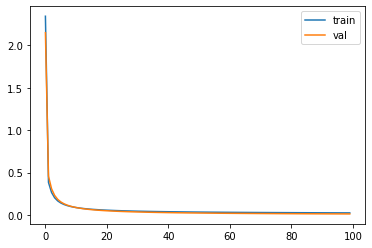

In [11]:
#@title Solution { display-mode: "form" }
def plot_train_val_loss(train_losses, val_losses):
  plt.plot(train_losses, label='train')
  plt.plot(val_losses, label='val')
  plt.legend();

plot_train_val_loss(train_losses, val_losses);

### Plot the decision boundary

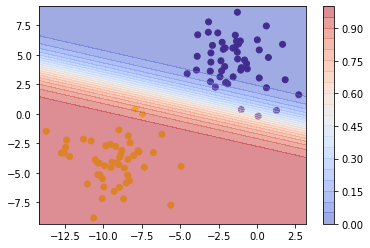

In [12]:
#@title Solution { display-mode: "form" }
def plot_contour(show_proba=True):
  x1 = jnp.linspace(x[:, 0].min()-0.5, x[:, 0].max()+0.5, 100)
  x2 = jnp.linspace(x[:, 1].min()-0.5, x[:, 1].max()+0.5, 100)
  X1, X2 = jnp.meshgrid(x1, x2)
  X = jnp.array([(x11, x22) for x11, x22 in zip(X1.flatten(), X2.flatten())])
  X = poly.transform(X)
  y_pred = predict_fn(theta, X)
  if not show_proba:
    y_pred = y_pred >= 0.5
  plt.scatter(x[:, 0], x[:, 1], c=y);
  plt.contourf(X1, X2, y_pred.reshape(100, 100), alpha=0.5, cmap='coolwarm', levels=20);
  plt.colorbar()

plot_contour()

### Compute accuracy on test dataset

In [13]:
#@title Solution { display-mode: "form" }
y_pred_proba = jax.nn.sigmoid(x_test@theta)
y_pred = y_pred_proba >= 0.5
accuracy_score(y_true=y_test, y_pred=y_pred)

1.0

### Try another dataset

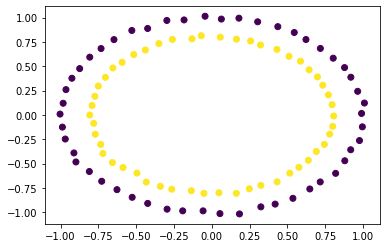

In [14]:
### Concentric circles
x, y = make_circles(n_samples=100, random_state=0, noise=0.01)
plt.scatter(x[:, 0], x[:, 1], c=y);

### Transform features

Let us add bias using `PolynomialFeatures`.

In [15]:
#@title Solution { display-mode: "form" }
poly = PolynomialFeatures(degree=1, include_bias=True)
x_transformed = poly.fit_transform(x)
x_transformed.shape

(100, 3)

### Train test validation split as earlier

In [16]:
#@title Solution { display-mode: "form" }
x_train, y_train, x_val, y_val, x_test, y_test = get_train_val_test_split(x_transformed, y)
x_train.shape, x_val.shape, x_test.shape

((72, 3), (8, 3), (20, 3))

### Optimize parameters using functions defined earlier

In [17]:
#@title Solution { display-mode: "form" }
theta = jnp.array([0.1, 0.2, 0.3])
n_iterations = 500
theta, train_losses, val_losses = train_fn(theta)

### Plot loss v/s iterations

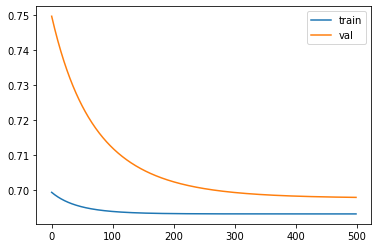

In [18]:
#@title Solution { display-mode: "form" }
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

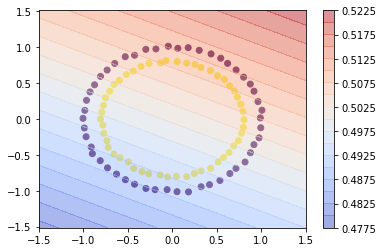

In [19]:
#@title Solution { display-mode: "form" }
plot_contour()

In [20]:
#@title Solution { display-mode: "form" }
y_pred_proba = jax.nn.sigmoid(x_test@theta)
y_pred = y_pred_proba >= 0.5
accuracy_score(y_true=y_test, y_pred=y_pred)

0.55

### Transform features

Current set of features are not able to learn the decision boundary properly. Let us include squared terms in our features. 

In [21]:
#@title Solution { display-mode: "form" }
poly = PolynomialFeatures(degree=2, include_bias=True)
x_transformed = poly.fit_transform(x)
x_transformed.shape

(100, 6)

In [22]:
#@title Solution { display-mode: "form" }
x_train, y_train, x_val, y_val, x_test, y_test = get_train_val_test_split(x_transformed, y)
x_train.shape, x_val.shape, x_test.shape

((72, 6), (8, 6), (20, 6))

In [23]:
#@title Solution { display-mode: "form" }
theta = jnp.array([2.0, 1.0, 3.0, 1.0, 0.1, 0.5])
n_iterations = 1000
learning_rate= 0.1
theta, train_losses, val_losses = train_fn(theta)

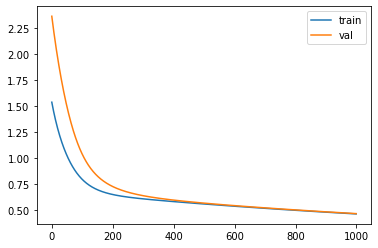

In [24]:
#@title Solution { display-mode: "form" }
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

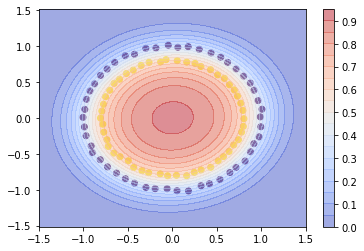

In [29]:
#@title Solution { display-mode: "form" }

plot_contour()

In [30]:
#@title Solution { display-mode: "form" }
y_pred_proba = jax.nn.sigmoid(x_test@theta)
y_pred = y_pred_proba >= 0.5
accuracy_score(y_true=y_test, y_pred=y_pred)

1.0

In [27]:
theta

DeviceArray([ 2.3522823 ,  0.0307414 ,  0.00674327, -2.8687317 ,
              0.23683539, -3.0611947 ], dtype=float32)